## SVM 만들어보기

- 어떤 수식이 필요할까? - 
https://ratsgo.github.io/machine%20learning/2017/05/23/SVM/

- 마진을 최대화 시키는 경계를 찾는 목적식, 이 목적식에 대한 제약식
- '제약 조건이 있는 최적화 문제를 풀기' -> '최적점이 되기위한 조건식을 푸는 문제'로 바꿔주는 라그랑주 승수법 사용
- 라그랑주 함수에서 나오는 알파는 KKT(Karush-Kuhn-Tucker) 승수
- KKT 조건을 만족하는 정류점(stationary point)에 해가 있음(존재한다면)
- 라그랑주 함수가 KTT 조건을 만족하는지 보이고(결과는 당연히 필요충분을 만족함)
- 정류점의 속성을 대입해서 SVM문제를 쌍대 형식으로 나타내고 그 함수를 최소화하는 (+ 모든 알파추정치에서 양수인) 알파 추정치를 찾는 문제( = 쌍대 문제 )
- 쌍대 문제에서 구한 w와 b의 추정치로 원래 마진에 업데이트<br/><br/>

- kernel의 핵심 : (2차 다항식)변환된 벡터의 스칼라 곱이 원래 벡터 스칼라 곱의 제곱과 같음


#### sklearn 패키지의 svm... 복잡하다..
- https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/svm/base.py

## 선형 분류기

### robust linear discrimination

In [16]:
import numpy as np                     #계산은 해야하니...
import matplotlib.pyplot as plt        #결과를 그래프로
#!pip install cvxpy --user
import cvxpy                           #convex function을 풀어주는 패키지 그냥 제약식에서 최적화된 해를 찾아주는 기능으로 이해하고 패스
from cvxpy import *                    #http://www.cvxpy.org

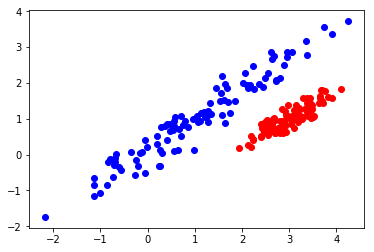

In [47]:
# d차원 클래스당 m개의 점
d = 2   # Dimension of problem. We'll leave at 2 for now.
m = 100 # Number of points in each class
n = 100  

x_center = [1,1]  # E.g. [1,1]
y_center = [3,1]  # E.g. [2,2]

# 랜덤시드
np.random.seed(8)  

# Define random orientations for the two clusters
orientation_x = np.random.rand(2,2)
orientation_y = np.random.rand(2,2)

# Generate unit-normal elements, but clip outliers.
rx = np.clip(np.random.randn(m,d),-2,2)
ry = np.clip(np.random.randn(n,d),-2,2)
x = x_center + np.dot(rx,orientation_x)
y = y_center + np.dot(ry,orientation_y)

# Check out our clusters!
plt.scatter(x[:,0],x[:,1],color='blue')
plt.scatter(y[:,0],y[:,1],color='red')

In [52]:
## OPTIMIZATION (cvxpy를 이용해서)

#사용될 변수 지정
a = Variable(d)
b = Variable()
t = Variable()

#t를 최대화한 것을 목적함수로
obj = Maximize(t)

#제약식은 a의 전치행렬과 x의 내적 - 절편 b 
x_constraints = [a.T * x[i] - b >= t  for i in range(m)]
y_constraints = [a.T * y[i] - b <= -t for i in range(n)]

#등식을 다음과 같이 쓸 수 있음
constraints = x_constraints +  y_constraints + [norm(a,2) <= 1]

#cvxpy로 풀기
prob = Problem(obj, constraints)

prob.solve()
print("Problem Status: %s"%prob.status)

Problem Status: optimal


In [54]:
#그래프로 그려보자
def plotClusters(x,y,a,b,t):
    # Takes in a set of datapoints x and y for two clusters,
    #  the hyperplane separating them in the form a'x -b = 0,
    #  and a slab half-width t
    d1_min = np.min([x[:,0],y[:,0]])
    d1_max = np.max([x[:,0],y[:,0]])
    # Line form: (-a[0] * x - b ) / a[1]
    d2_atD1min = (-a[0]*d1_min + b ) / a[1]
    d2_atD1max = (-a[0]*d1_max + b ) / a[1]

    sup_up_atD1min = (-a[0]*d1_min + b + t ) / a[1]
    sup_up_atD1max = (-a[0]*d1_max + b + t ) / a[1]
    sup_dn_atD1min = (-a[0]*d1_min + b - t ) / a[1]
    sup_dn_atD1max = (-a[0]*d1_max + b - t ) / a[1]

    # Plot the clusters!
    plt.scatter(x[:,0],x[:,1],color='blue')
    plt.scatter(y[:,0],y[:,1],color='red')
    plt.plot([d1_min,d1_max],[d2_atD1min,d2_atD1max],color='black')
    plt.plot([d1_min,d1_max],[sup_up_atD1min,sup_up_atD1max],'--',color='gray')
    plt.plot([d1_min,d1_max],[sup_dn_atD1min,sup_dn_atD1max],'--',color='gray')
    plt.ylim([np.floor(np.min([x[:,1],y[:,1]])),np.ceil(np.max([x[:,1],y[:,1]]))])

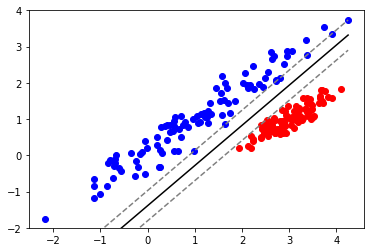

In [55]:
# Typecast and plot these initial results

a = a.value
b = b.value
t = t.value

plotClusters(x,y,a,b,t)

### support vector classifier

(-1.0, 3.0)

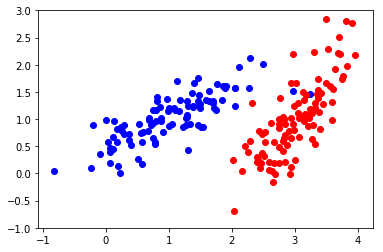

In [56]:
#이번에는 좀 더 지저분하게 샘플 데이터를 만들어보기
np.random.seed(2)

orientation_x = np.random.rand(2,2)
orientation_y = np.random.rand(2,2)

x = x_center + np.dot(np.random.randn(m,d),orientation_x)
y = y_center + np.dot(np.random.randn(n,d),orientation_y)

# Check out our clusters!
ax = plt.subplot(111)
plt.scatter(x[:,0],x[:,1],color='blue')
plt.scatter(y[:,0],y[:,1],color='red')
ax.set_ylim([np.floor(np.min([x[:,1],y[:,1]])),np.ceil(np.max([x[:,1],y[:,1]]))])

In [64]:
#cvxpy로 최적화 하기

# 변수 정해주기
a = Variable(d)
b = Variable()
u = Variable(m)
v = Variable(n)

#목적함수를 최소화하는 값 찾기
obj = Minimize(np.ones(m)*u + np.ones(n)*v)

#제약 조건
x_constraints = [a.T * x[i] - b >= 1 - u[i]  for i in range(m)]
y_constraints = [a.T * y[i] - b <= -1 + v[i] for i in range(n)]
u_constraints = [u[i] >= 0  for i in range(m)]
v_constraints = [v[i] >= 0  for i in range(n)]

#제약식
constraints = x_constraints +  y_constraints + u_constraints + v_constraints

#최적화하는 해 구하기
prob = Problem(obj, constraints)

prob.solve()
print("Problem Status: %s"%prob.status)

Problem Status: optimal


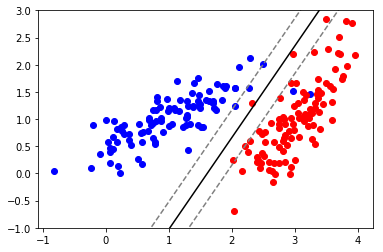

In [65]:
plotClusters(x,y,a.value,b.value,1)

### Canonical Support Vector - RBF

In [67]:
#RBF

gamma = Parameter()
gamma.value = 0.4

#감마를 넣어서 목적함수 RBF로 
obj = Minimize(norm(a,2) + gamma*(np.ones(m)*u + np.ones(n)*v) )

#제약식
constraints = x_constraints +  y_constraints + u_constraints + v_constraints


prob = Problem(obj, constraints)

prob.solve()
print("Problem Status: %s"%prob.status)
## Plotting the results

Problem Status: optimal


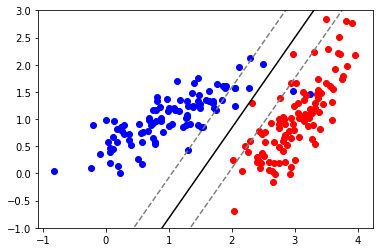

In [68]:
plotClusters(x,y,a.value,b.value,1)

In [69]:
#감마 값에 따라 마진이 변함
gamma.value = 0.05
prob.solve()

2.5003140492122213

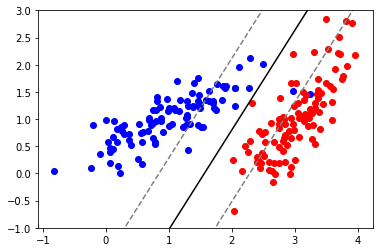

In [70]:
plotClusters(x,y,a.value,b.value,1)

## sklearn으로는?

In [71]:
data   = np.vstack([x,y])
labels = np.vstack([ np.zeros([m,1]), np.ones([n,1]) ]).ravel()

In [72]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1-0.05)
clf.fit(data,labels)

SVC(C=0.95, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

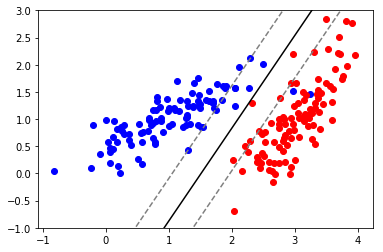

In [75]:
def plotClusters_sklearn(x,y,a,b,t):
    # Takes in a set of datapoints x and y for two clusters,
    #  the hyperplane separating them in the form a'x -b = 0,
    #  and a slab half-width t
    d1_min = np.min([x[:,0],y[:,0]])
    d1_max = np.max([x[:,0],y[:,0]])
    # Line form: (-a[0] * x - b ) / a[1]
    d2_atD1min = (-a[0]*d1_min + b ) / a[1]
    d2_atD1max = (-a[0]*d1_max + b ) / a[1]

    sup_up_atD1min = (-a[0]*d1_min + b + t ) / a[1]
    sup_up_atD1max = (-a[0]*d1_max + b + t ) / a[1]
    sup_dn_atD1min = (-a[0]*d1_min + b - t ) / a[1]
    sup_dn_atD1max = (-a[0]*d1_max + b - t ) / a[1]

    # Plot the clusters!
    plt.scatter(x[:,0],x[:,1],color='blue')
    plt.scatter(y[:,0],y[:,1],color='red')
    plt.plot([d1_min,d1_max],[d2_atD1min[0,0],d2_atD1max[0,0]],color='black')
    plt.plot([d1_min,d1_max],[sup_up_atD1min[0,0],sup_up_atD1max[0,0]],'--',color='gray')
    plt.plot([d1_min,d1_max],[sup_dn_atD1min[0,0],sup_dn_atD1max[0,0]],'--',color='gray')
    plt.ylim([np.floor(np.min([x[:,1],y[:,1]])),np.ceil(np.max([x[:,1],y[:,1]]))])


a1 = -np.matrix(clf.coef_).T
b1 = clf.intercept_
plotClusters_sklearn(x,y,a1,b1,1)